# **Unsupervised Learning Project**

## Problem statement

**Context**

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. The Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

**Objective**

To identify different segments in the existing customers, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

**Data Description**

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online, and through a call center).

**Data Dictionary**

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that the customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Import all the necessary libraries

In [218]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet


# to perform PCA
from sklearn.decomposition import PCA

## Loading the dataset

In [219]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [220]:
input_data = pd.read_excel("/content/drive/MyDrive/Great learning/Mod 6 Unsupervised learning/Project/coded/Credit Card Customer Data.xlsx")
data = input_data.copy()

## Data Overview

In [221]:
data.head().T

,0,1,2,3,4
Sl_No,1,2,3,4,5
Customer Key,87073,38414,17341,40496,47437
Avg_Credit_Limit,100000,50000,50000,30000,100000
Total_Credit_Cards,2,3,7,5,6
Total_visits_bank,1,0,1,1,0
Total_visits_online,1,10,3,1,12
Total_calls_made,0,9,4,4,3


### Checking the shape of the dataset

In [222]:
print('There are',data.shape[0], 'rows and', data.shape[1], 'columns in the dataset')

There are 660 rows and 7 columns in the dataset


In [223]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


### Standardizing Column Names

In [224]:
data.columns = [i.replace(" ", "_").lower() for i in data.columns]

In [225]:
data.columns

Index(['sl_no', 'customer_key', 'avg_credit_limit', 'total_credit_cards',
       'total_visits_bank', 'total_visits_online', 'total_calls_made'],
      dtype='object')

### Checking the data types of the columns for the dataset

In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   sl_no                660 non-null    int64
 1   customer_key         660 non-null    int64
 2   avg_credit_limit     660 non-null    int64
 3   total_credit_cards   660 non-null    int64
 4   total_visits_bank    660 non-null    int64
 5   total_visits_online  660 non-null    int64
 6   total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


All the columns are integer columns

### Checking for missing values

In [227]:
data.isnull().sum()

,0
sl_no,0
customer_key,0
avg_credit_limit,0
total_credit_cards,0
total_visits_bank,0
total_visits_online,0
total_calls_made,0


There is no missing values in the data.

### Checking for duplicate values

In [228]:
data.duplicated().sum()

0

There is no duplicate rows in the data.

### Dropping the columns with all unique values

In [229]:
data.sl_no.nunique()

660

* The `Sl_No` column contains only unique values and it does not provide any information, so we can drop it.

In [230]:
data = data.drop(["sl_no"], axis=1)

In [231]:
data.customer_key.nunique()

655

It seems that there are 5 duplicates in the customer key column.

In [232]:
# Customer key with duplicate values
data[data['customer_key'].duplicated()]['customer_key']

,customer_key
332,47437
398,96929
432,37252
541,50706
632,97935


In [233]:
data[data['customer_key'].isin(data[data['customer_key'].duplicated()]['customer_key'])].sort_values('customer_key')

,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
48,37252,6000,4,0,2,8
432,37252,59000,6,2,1,2
4,47437,100000,6,0,12,3
332,47437,17000,7,3,1,0
411,50706,44000,4,5,0,2
541,50706,60000,7,5,2,2
391,96929,13000,4,5,0,0
398,96929,67000,6,2,2,2
104,97935,17000,2,1,2,10
632,97935,187000,7,1,7,0


The data look different from each other for the same `Customer Key`. So let's assume this may be due to mistake done while assigning key and consider these two customers as two different customers as of now. After the clustering, we categories the groups according to these sets of records.

### Statistical summary of the dataset

In [234]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.5,99843.0
avg_credit_limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.0,200000.0
total_credit_cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.0,10.0
total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.0,5.0
total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.0,15.0
total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.0,10.0


- Average credit limit has median value of $18,000 and seems to has outliers.
- Total number of credit cards ranges from 1 to 10 where a most of them are less than 6.
- Total annual visits to the bank ranges from 0 to 5 with mean and median 2.
- Total annual visits on online ranges from 0 to 15 with median 2 and seems to has outliers.
- Total calls made to the bank ranges from 0 to 10 with median 3 and seems to has outliers.

## Exploratory Data Analysis

### Univariate Analysis

Different types of Univariate Analysis that can be done:
- Univariate Analysis of  Numerical Variable.
- Univariate Analysis of Categorical Variable.

In [235]:
data.nunique()

,0
customer_key,655
avg_credit_limit,110
total_credit_cards,10
total_visits_bank,6
total_visits_online,16
total_calls_made,11


**Numerical variables**

- customer_key
- avg_credit_limit

**Categorical variables**

- total_credit_cards
- total_visits_bank
- total_visits_online
- total_calls_made


In [236]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [237]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

#### Numerical variable

##### Observation on customer_key

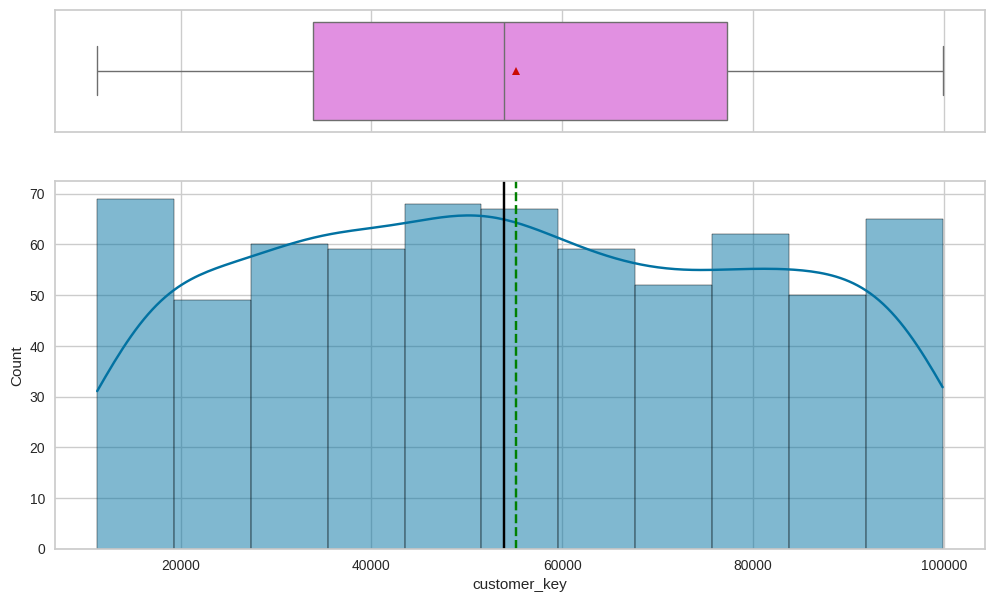

In [238]:
histogram_boxplot(data, 'customer_key', kde=True)

customer_key ranges from	11265	to 99843, with mean 55141.44 and median 53874.5

##### Observation on avg_credit_limit

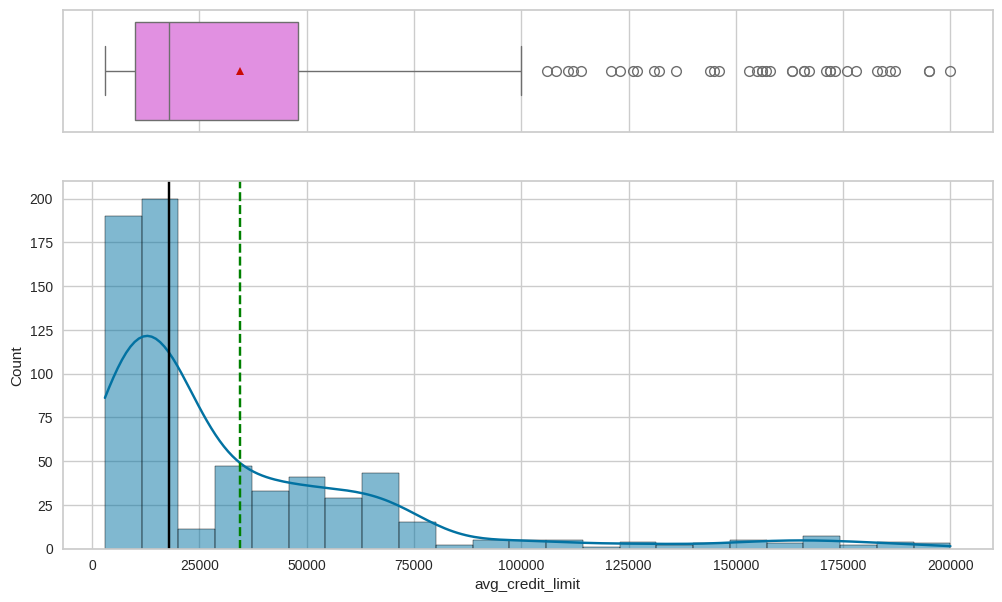

In [239]:
histogram_boxplot(data, 'avg_credit_limit', kde=True)

- This distribution is heavily right skewed with outliers.
- Credit limit greater than $100,000 are outliers.

#### Categorical variable

In [240]:
# Making a list of all categorical variables
cat_cols =  ['total_credit_cards', 'total_visits_bank', 'total_visits_online', 'total_calls_made']

# Printing the count of unique categorical levels in each column
for column in cat_cols:
    print(data[column].value_counts())
    print("-" * 50)

total_credit_cards
4     151
6     117
7     101
5      74
2      64
1      59
3      53
10     19
9      11
8      11
Name: count, dtype: int64
--------------------------------------------------
total_visits_bank
2    158
1    112
0    100
3    100
5     98
4     92
Name: count, dtype: int64
--------------------------------------------------
total_visits_online
2     189
0     144
1     109
4      69
5      54
3      44
15     10
7       7
10      6
12      6
8       6
11      5
13      5
9       4
14      1
6       1
Name: count, dtype: int64
--------------------------------------------------
total_calls_made
4     108
0      97
2      91
1      90
3      83
6      39
7      35
9      32
8      30
5      29
10     26
Name: count, dtype: int64
--------------------------------------------------


##### Observation on total_credit_cards

<ipython-input-237-0aaf8dec4340>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


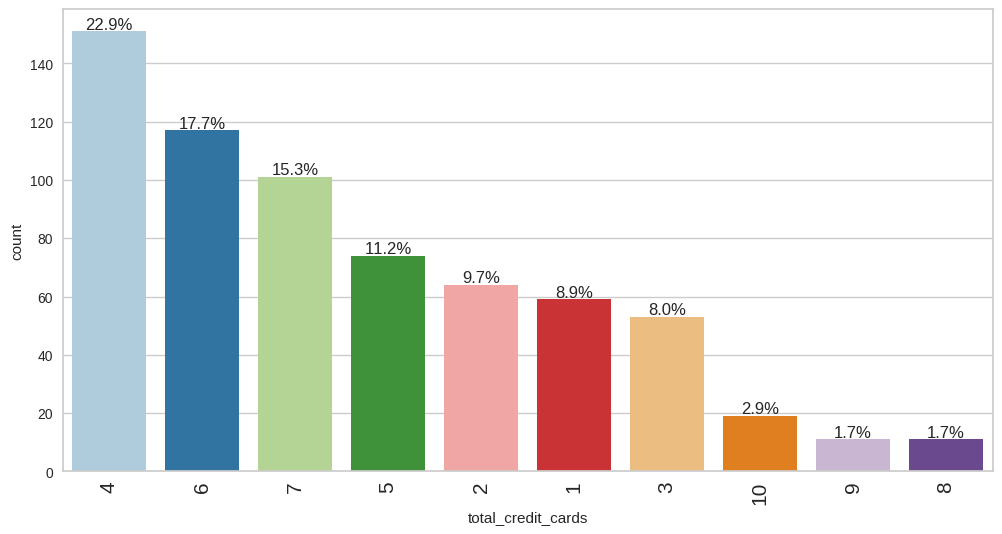

In [241]:
labeled_barplot(data, "total_credit_cards", perc=True)

- Total credit cards purchased ranges from 1 to 10.
- Most of the people prefers 4 credit cards and least number of people prefer more than 7 cards.
- 19 customers purchased maximum number of cards (10 cards).


##### Observation on total_visits_bank

<ipython-input-237-0aaf8dec4340>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


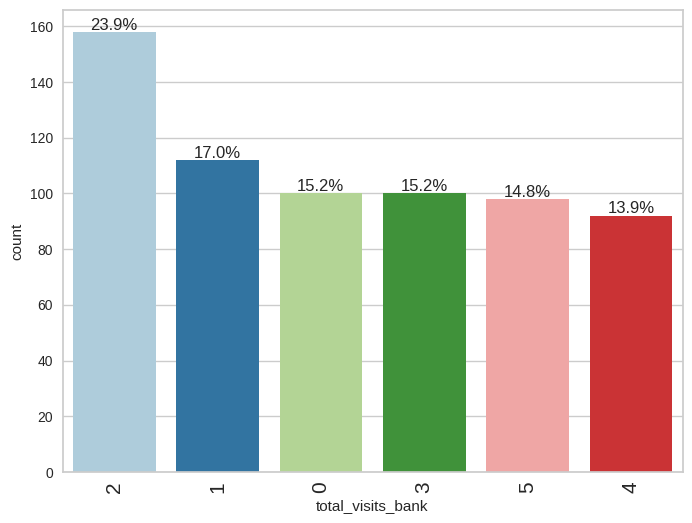

In [242]:
labeled_barplot(data, "total_visits_bank", perc=True)

- Most of people visit the bank twice a year.
- Less number of people visit the bank more than 3 times in a year.
- 100 customers have never visited the bank.

##### Observation on total_visits_online

<ipython-input-237-0aaf8dec4340>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


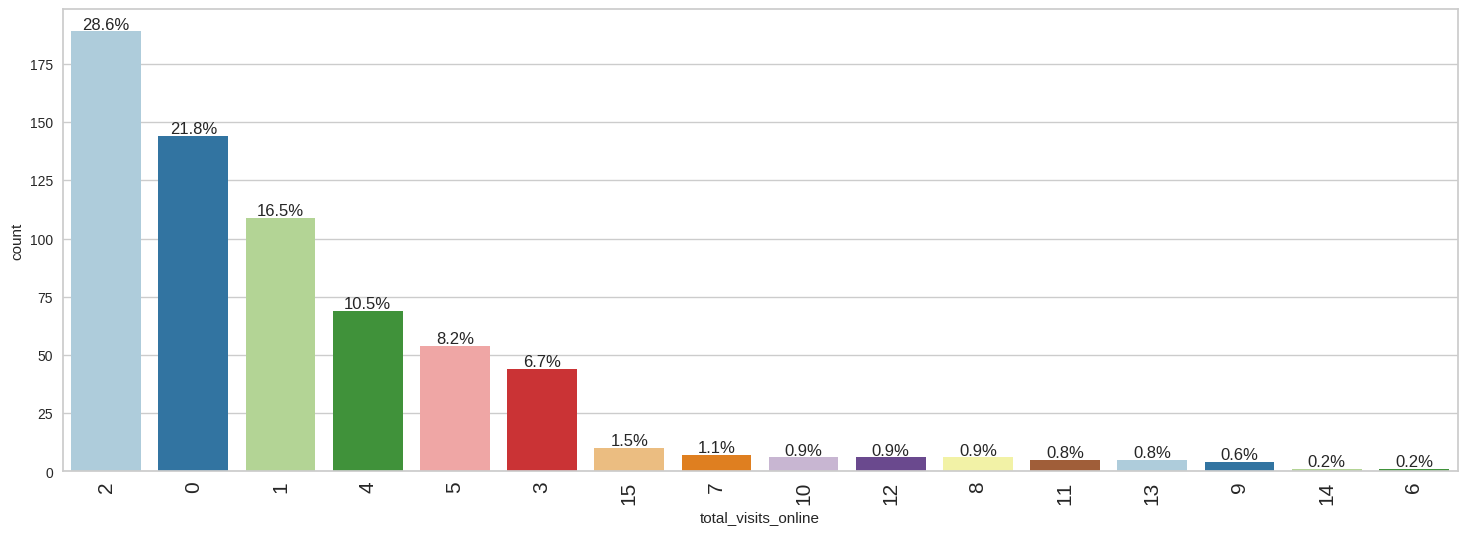

In [243]:
labeled_barplot(data, "total_visits_online", perc=True)

- Most of people visit the bank website twice a year.
- Less number of people visit the bank website more than 5 times in a year.
- 144 customers have never visited the bank website on online.

##### Observation on total_calls_made

<ipython-input-237-0aaf8dec4340>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


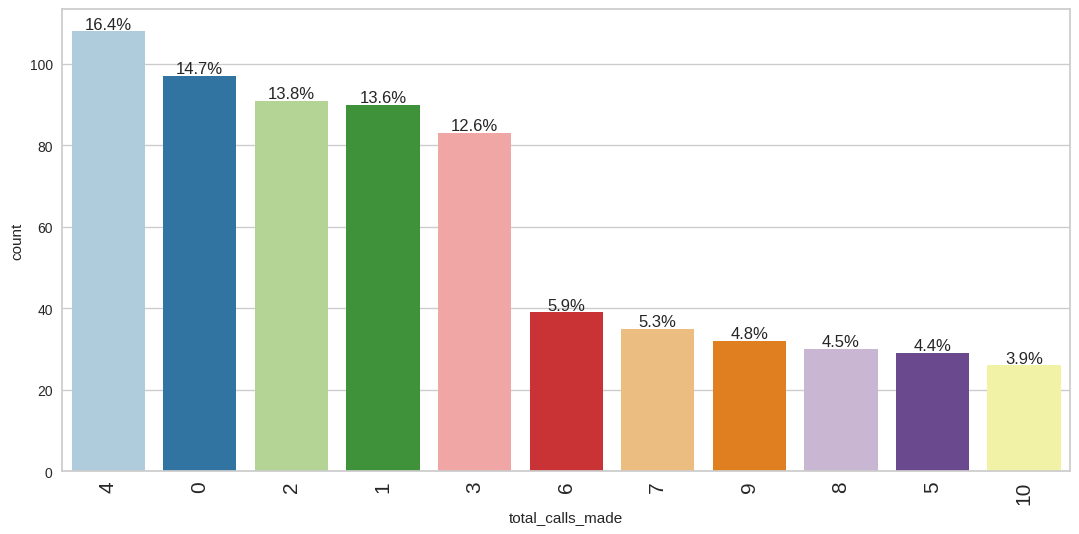

In [244]:
labeled_barplot(data, "total_calls_made", perc=True)

- Most of the customers make 4 phone calls to the bank or its customer service department.
- Least number of customers make 10 phone calls to the bank
- 144 customers have never made a call to the bank.

### Bivariate Analysis

Different types of Bivariate Analysis that can be done:
- Bivariate Analysis of two Numerical Variables.
- Bivariate Analysis of two Categorical Variables.
- Bivariate Analysis of one Numerical Variable and one Categorical Variable.

#### Correlation by Heatmap

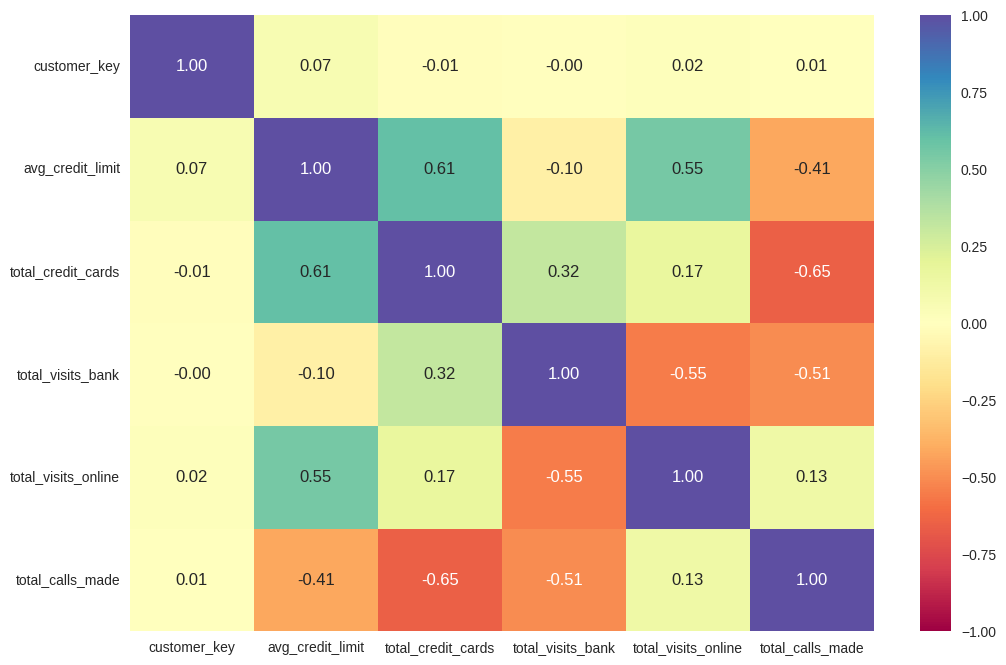

In [245]:
# Check for correlation among numerical variables
num_var = data.select_dtypes(include=np.number).columns.tolist()

corr = data[num_var].corr()

# plot the heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='Spectral')
plt.show()

- `customer_key` has no relation with other attributes.
- `avg_credit_limit`: It is positively correlated with the total credit cards and total visits on online and has negative correlation with total calls made.It has no relation with total number of visits to the bank.
- `total_credit_cards`: It is negatively correlated with the number of calls made and positively correlated with the total number of visits on bank.
- `total_visits_bank`: It is negatively correlated with online visits and calls made.
- `total_online_visits` has no relation with the number of calls made.

#### Pairplot of numerical variables

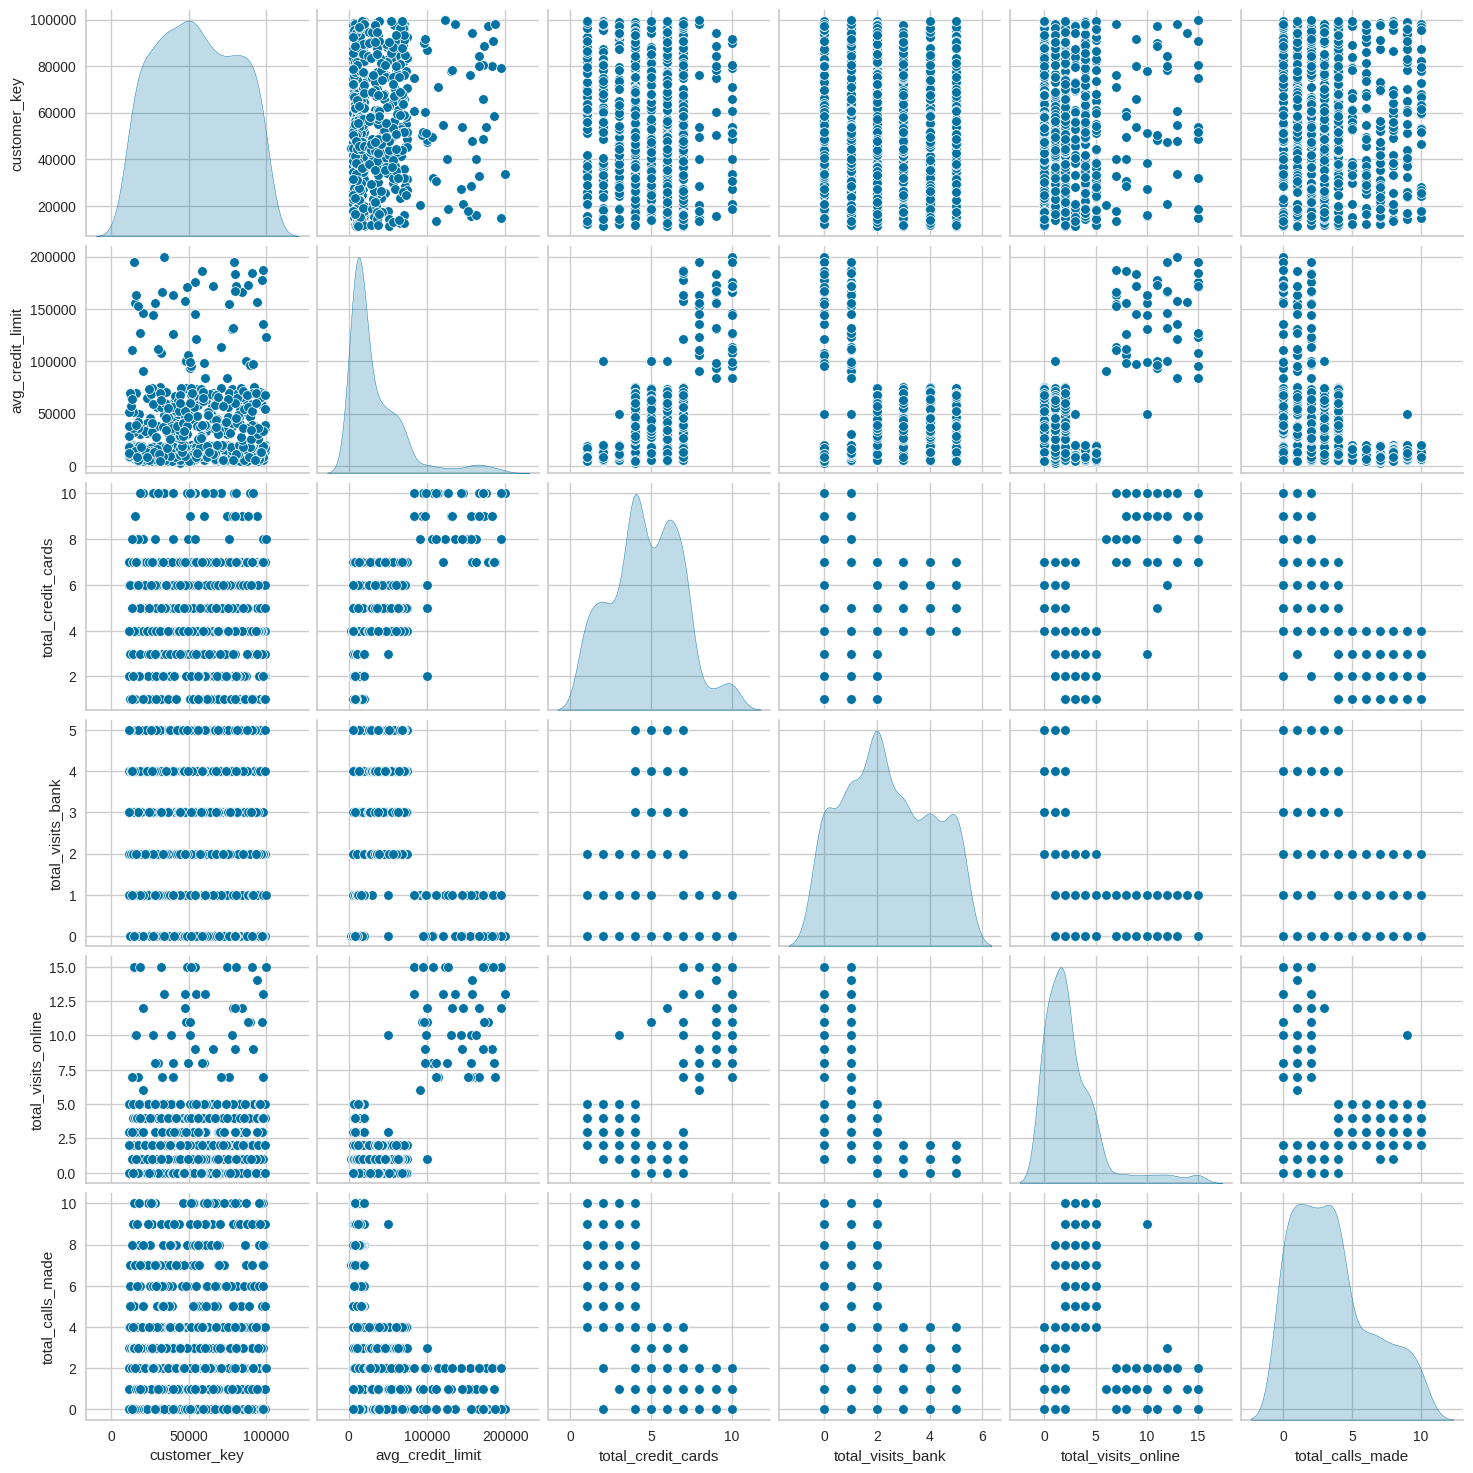

In [246]:
sns.pairplot(data=data[num_var], diag_kind="kde")
plt.show()

#### Observation on total_credit_cards Vs avg_credit_limit

<Axes: xlabel='total_credit_cards', ylabel='avg_credit_limit'>

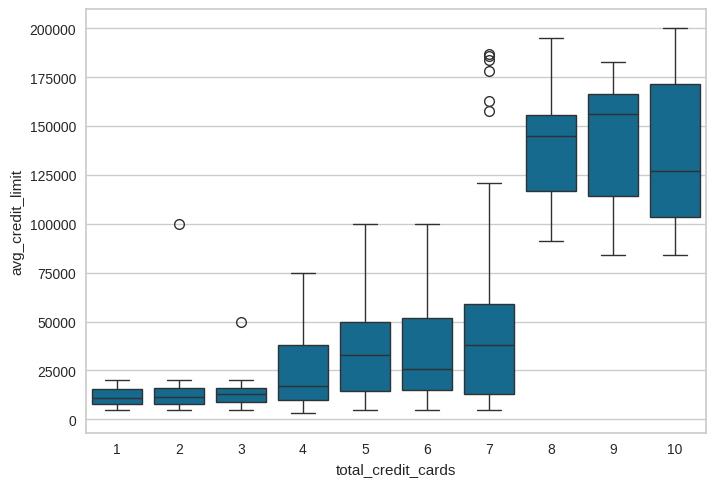

In [247]:
sns.boxplot(data, x='total_credit_cards', y='avg_credit_limit')

- Customers who have a greater number of credit cards have higher credit limit.
- Customers having credit cards less than 4 have least credit limit even less than `$25,000`.
- Customers having 4 to 7 credit cards have moderate credit limit even less than `$125,000`.
- Customers having credit cards greater than 7 have highest credit limit with minimum `$80,000` and maximum `$200,000`.

#### Observation on total_visits_bank Vs avg_credit_limit

<Axes: xlabel='total_visits_bank', ylabel='avg_credit_limit'>

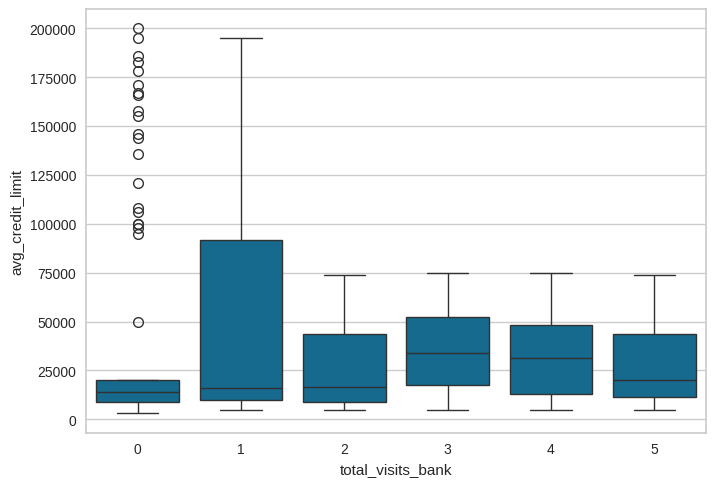

In [248]:
sns.boxplot(data, x='total_visits_bank', y='avg_credit_limit')

- Customers who visit bank frequently have lower credit limit.
- Customers who visit the bank once in a year have higher credit limit.
- Customers who visit the bank more than twice in a year have credit limit less than `$75,000`.

#### Observation on total_visits_online Vs avg_credit_limit

<Axes: xlabel='total_visits_online', ylabel='avg_credit_limit'>

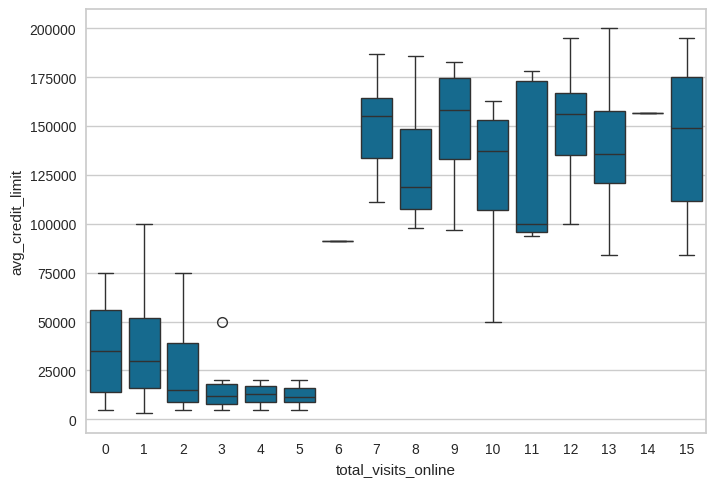

In [249]:
sns.boxplot(data, x='total_visits_online', y='avg_credit_limit')

In [250]:
data.loc[data['total_visits_online'] == 6]

,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
625,20337,91000,8,1,6,1


- Customers who visit bank website frequently have higher credit limit.
- Customers who visit the bank website on online more than 6 times in a year have higher credit limit.
- Customers who visit the bank website on online less than 6 times in a year have credit limit less than `$100,000`.
- Only one person (customer key: 20337) used bank website 6 times in a year has credit limit `$91,000`.

#### Observation on total_calls_made Vs avg_credit_limit

<Axes: xlabel='total_calls_made', ylabel='avg_credit_limit'>

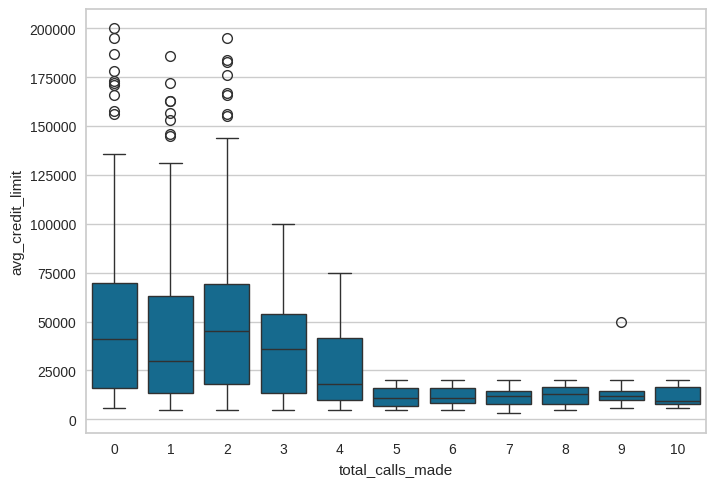

In [251]:
sns.boxplot(data, x='total_calls_made', y='avg_credit_limit')

- Customers with more phone call have lesser credit limit.
- Customers who made calls less than 3 have higher credit limit.
- Customers who made 3 calls have credit limit less than `$100,000`.
- Customers who made 4 calls have credit limit less than `$75,000`.
- Customers who made calls greater than 4 have lower credit limit.

### Insight from EDA

-
-
-

## Data Preprocessing

### Missing Value Treatment

In [252]:
data.isnull().sum()

,0
customer_key,0
avg_credit_limit,0
total_credit_cards,0
total_visits_bank,0
total_visits_online,0
total_calls_made,0


In [253]:
data.duplicated().sum()

0

### Feature Engineering

No need for feature engineering.

### Outlier detection

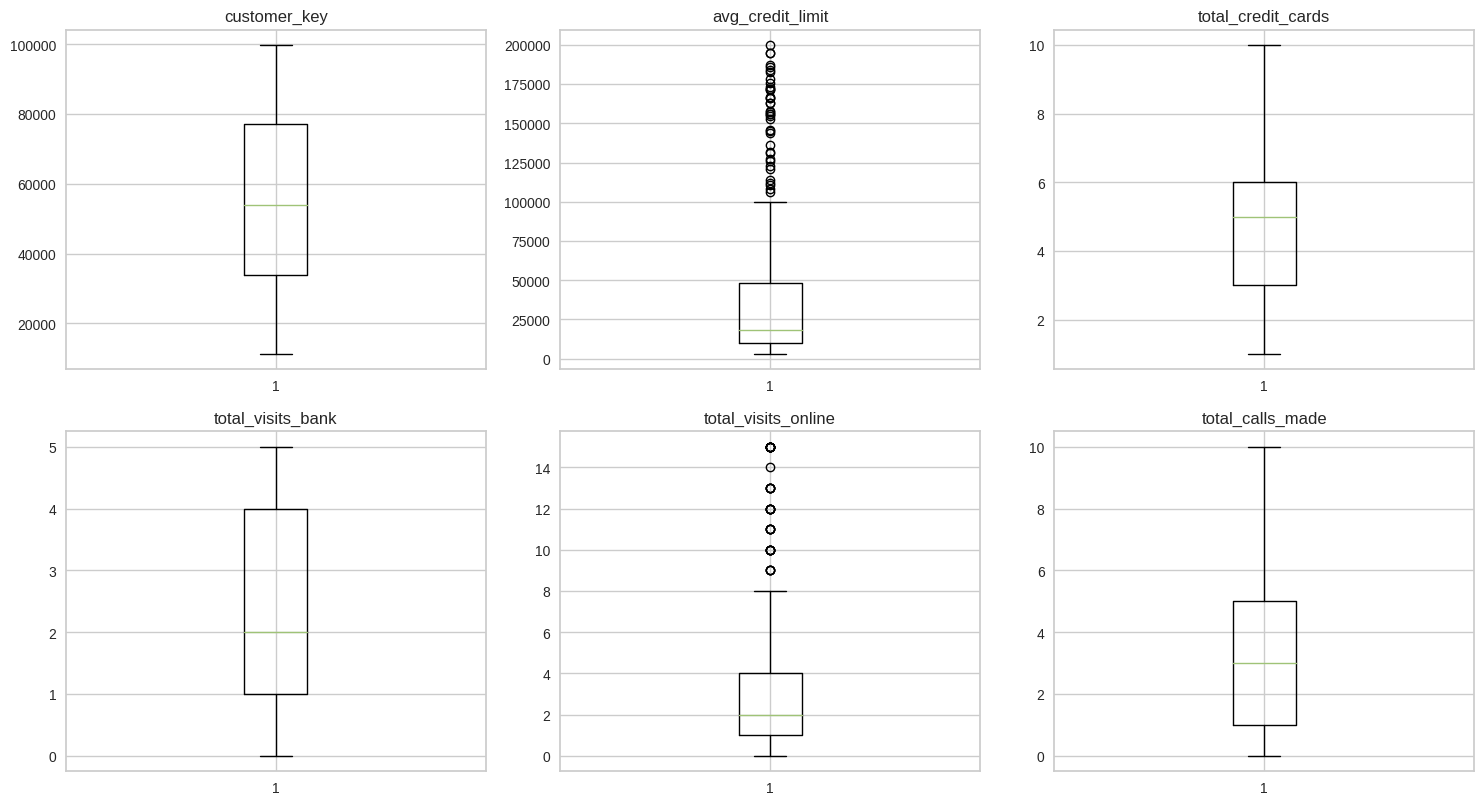

In [254]:
# outlier detection using boxplot
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(3, 3, i + 1)
    plt.boxplot(data[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

- Average credit limit and total visits online columns have outliers
- However, we will not treat them as they are proper values.

### Data Scaling

In [255]:
# Scaling the data set before clustering
scaler = StandardScaler()
subset = data[numeric_columns].copy()
subset_scaled = scaler.fit_transform(subset.iloc[:, :])

# Creating a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)
subset_scaled_df.head().T

,0,1,2,3,4
customer_key,1.246920,-0.653203,-1.476098,-0.571901,-0.300857
avg_credit_limit,1.740187,0.410293,0.410293,-0.121665,1.740187
total_credit_cards,-1.249225,-0.787585,1.058973,0.135694,0.597334
total_visits_bank,-0.860451,-1.473731,-0.860451,-0.860451,-1.473731
total_visits_online,-0.547490,2.520519,0.134290,-0.547490,3.202298
total_calls_made,-1.251537,1.891859,0.145528,0.145528,-0.203739


In [256]:
# creating dataframe copies for k-means and hierarchical clustering
km_df = data.copy()
hc_df = data.copy()

## Building model: K-means Clustering

K-means clustering is used to partition a dataset into different clusters. It groups data points into K clusters, where each data point belongs to the particular group with the nearest mean. We need to choose right value of k for clustering.

**Methods for choosing optimal K value:**
- Elbow Method: Plot the sum of squared distances from each point to its assigned cluster center for different values of K. We need to look on elbow in the graph where the rate of decrease sharply slows down which indicates an optimal K.
- Silhouette Score: It measures how similar an object is to its own cluster compared to other clusters. Higher Silhouette scores indicate better-defined clusters.

### Checking Elbow Plot

Number of Clusters: 1 	Average Distortion: 2.256953985735335
Number of Clusters: 2 	Average Distortion: 1.7858322163326603
Number of Clusters: 3 	Average Distortion: 1.5055314856497994
Number of Clusters: 4 	Average Distortion: 1.414717992857247
Number of Clusters: 5 	Average Distortion: 1.272781740716985
Number of Clusters: 6 	Average Distortion: 1.2266428799373534
Number of Clusters: 7 	Average Distortion: 1.179738177097504
Number of Clusters: 8 	Average Distortion: 1.1454398784037514
Number of Clusters: 9 	Average Distortion: 1.124025120239714


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

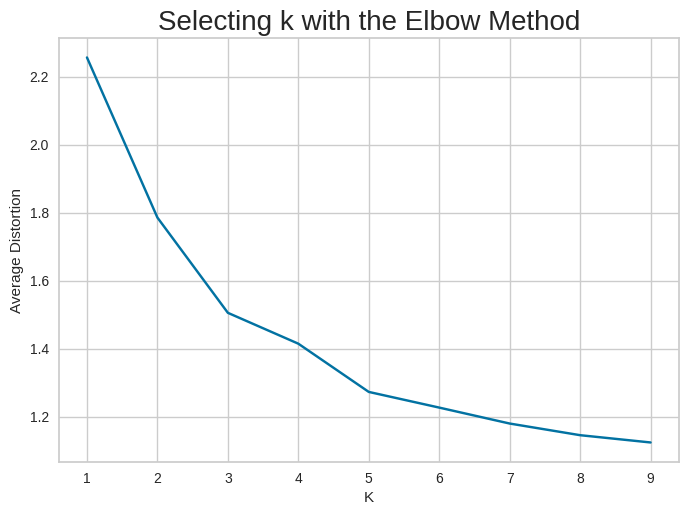

In [257]:
clusters = range(1, 10)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("K")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

The appropriate value of k from the elbow curve seems to be 3 or 4.

**Let's do further analysis to determine the optimal value of k**

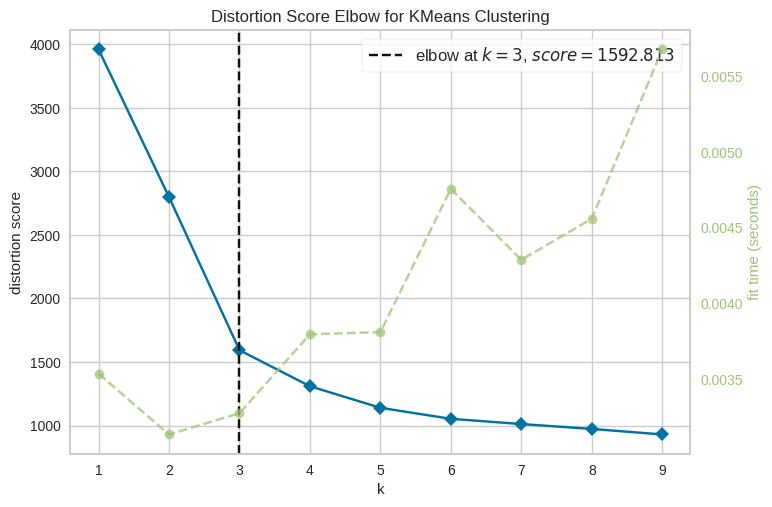

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [258]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(1, 10), timings=True)
visualizer.fit(subset_scaled_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure

### Checking Silhouette Scores

**Let's check the silhouette scores.**

For n_clusters = 2, silhouette score is 0.33817196365464486
For n_clusters = 3, silhouette score is 0.4177434852377372
For n_clusters = 4, silhouette score is 0.3228907072652812
For n_clusters = 5, silhouette score is 0.279267336060346
For n_clusters = 6, silhouette score is 0.2541106280450276
For n_clusters = 7, silhouette score is 0.2340040576707455
For n_clusters = 8, silhouette score is 0.23097708728224214
For n_clusters = 9, silhouette score is 0.20802674166507626


Text(0.5, 1.0, 'Selecting k with the Silhouette Scores')

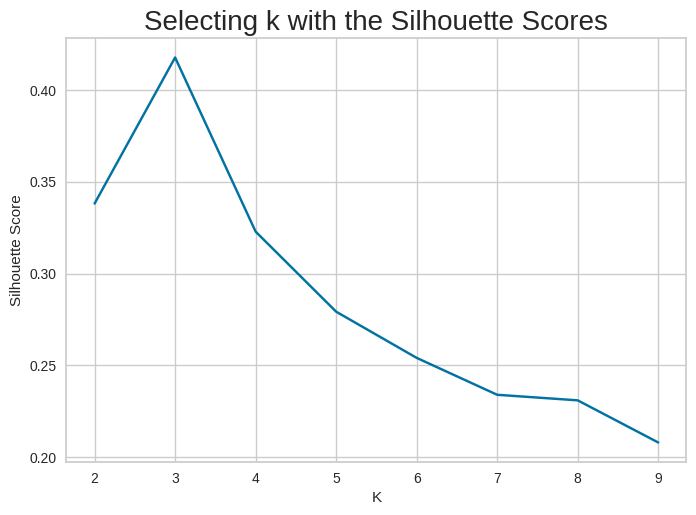

In [259]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Selecting k with the Silhouette Scores", fontsize=20)

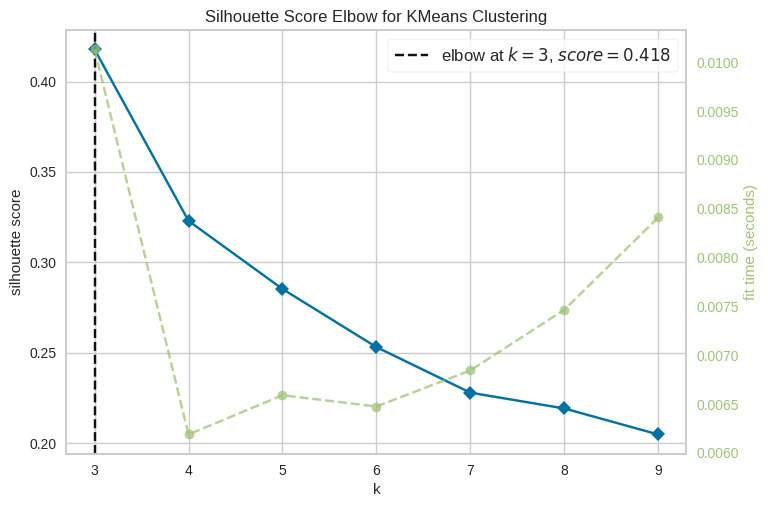

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [260]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(3, 10), metric="silhouette", timings=True)
visualizer.fit(subset_scaled_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure

From the silhouette scores, it seems that 3 is a good value of k.

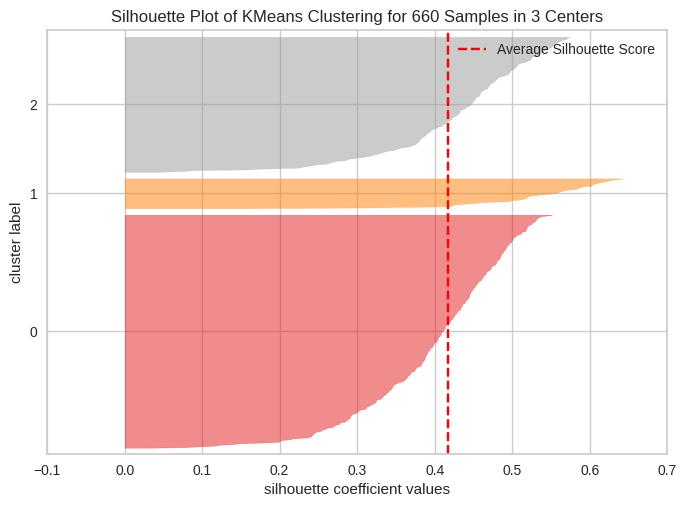

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [261]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

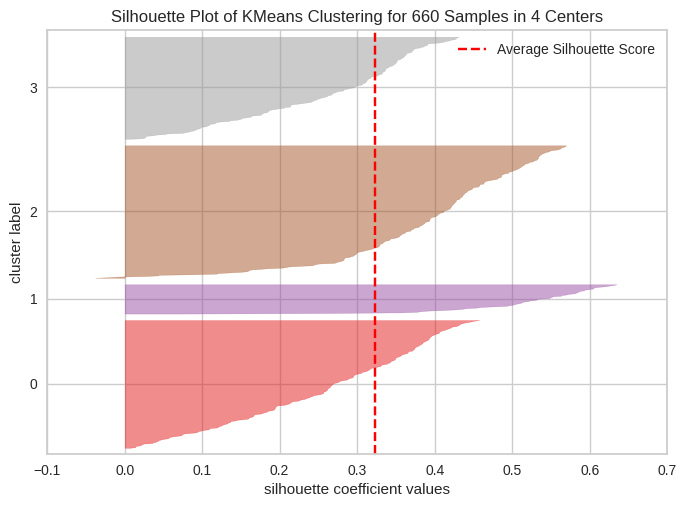

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [262]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

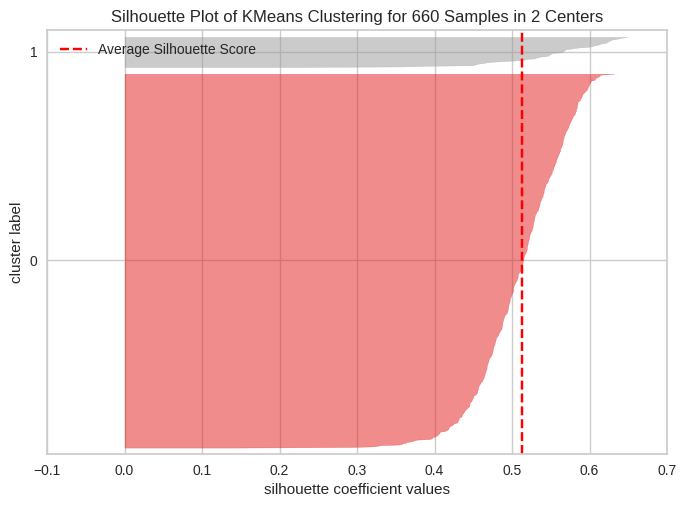

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [263]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

### Creating Final Model

**Let's take 3 as the appropriate no. of clusters as the silhouette score is high enough and there is kick at 3 in the elbow curve.**

In [264]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=0)

In [265]:
# adding kmeans cluster labels to the original dataframe
km_df["KM_segments"] = kmeans.labels_

### Cluster Profiling

In [266]:
pd.crosstab(km_df.KM_segments, km_df.total_visits_bank)

total_visits_bank,0,1,2,3,4,5
KM_segments,,,,,,
0,0,3,93,100,92,98
1,20,30,0,0,0,0
2,80,79,65,0,0,0


In [267]:
pd.crosstab(km_df.KM_segments, km_df.total_visits_online)

total_visits_online,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
KM_segments,,,,,,,,,,,,,,,,
0,144,106,135,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,7,6,4,5,5,6,5,1,10
2,0,3,54,43,69,54,0,0,0,0,1,0,0,0,0,0


In [268]:
pd.crosstab(km_df.KM_segments, km_df.total_calls_made)

total_calls_made,0,1,2,3,4,5,6,7,8,9,10
KM_segments,,,,,,,,,,,
0,81,74,72,82,77,0,0,0,0,0,0
1,16,15,18,1,0,0,0,0,0,0,0
2,0,1,1,0,31,29,39,35,30,32,26


In [269]:
pd.crosstab(km_df.KM_segments, km_df.total_credit_cards)

total_credit_cards,1,2,3,4,5,6,7,8,9,10
KM_segments,,,,,,,,,,
0,0,1,0,102,73,116,94,0,0,0
1,0,0,0,0,1,1,7,11,11,19
2,59,63,53,49,0,0,0,0,0,0


In [270]:
km_profiling = km_df.groupby("KM_segments").mean(numeric_only = True)
km_profiling["count_of_customers"] = (
    km_df.groupby("KM_segments")["customer_key"].count().values
)

In [271]:
# let's display cluster profiles
km_profiling.style.highlight_max(color="blue", axis=0).highlight_min(color='green')

,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,count_of_customers
KM_segments,,,,,,,
0,54881.329016,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,55239.830357,12174.107143,2.410714,0.933036,3.553571,6.870536,224


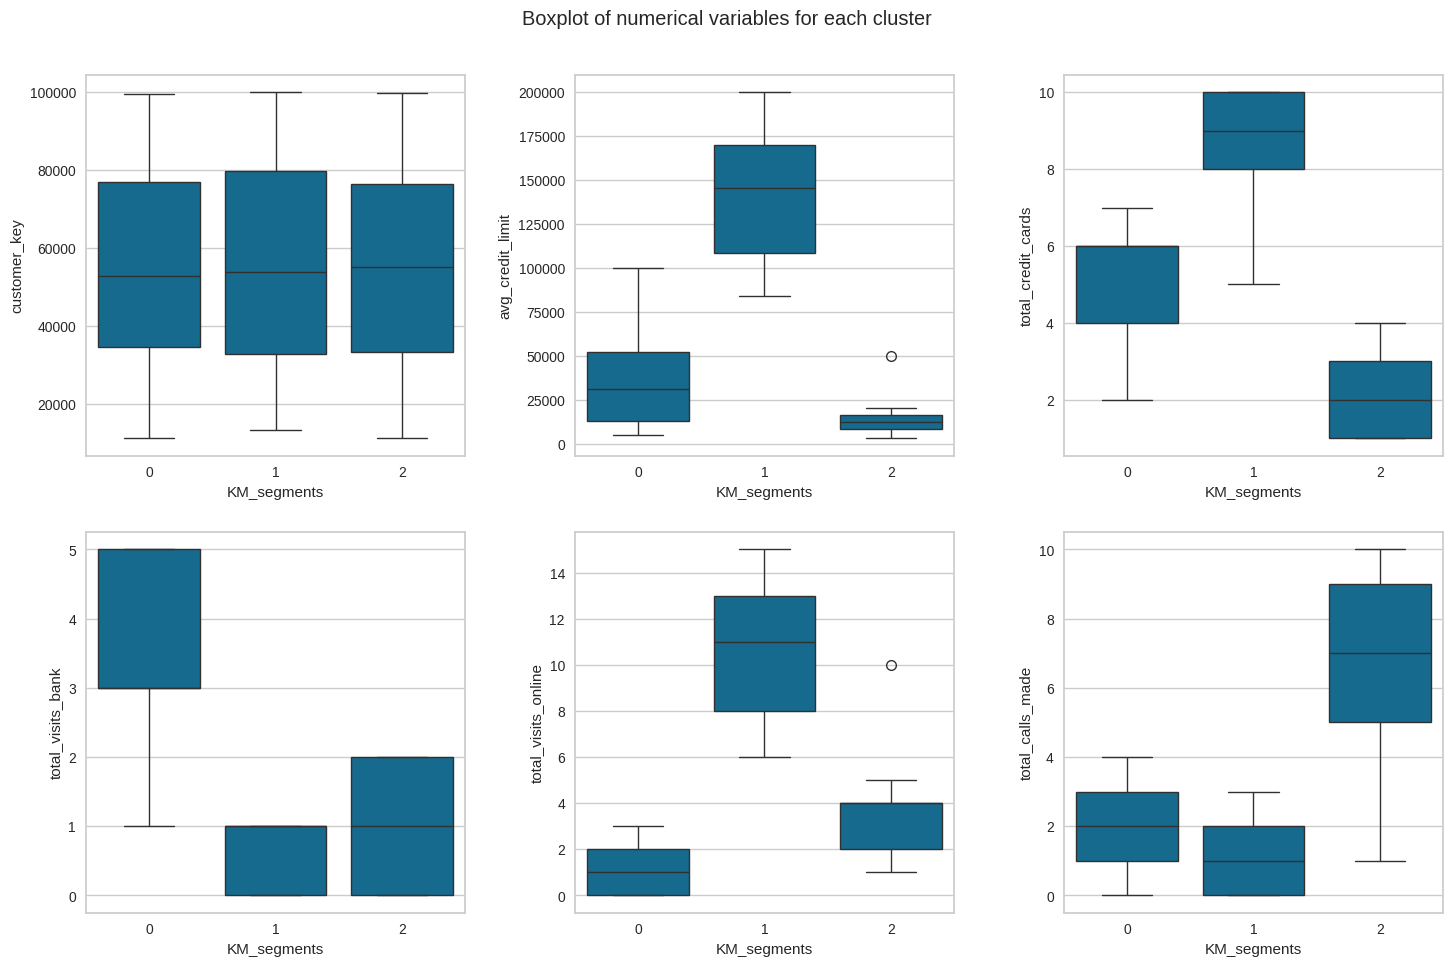

In [272]:
plt.figure(figsize=(15, 10))
plt.suptitle("Boxplot of numerical variables for each cluster")

for i, variable in enumerate(numeric_columns):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=km_df, x="KM_segments", y=variable)

plt.tight_layout(pad=2.0)

### Insights

**Cluster 0**:
  - The average credit limit for this cluster is under $33,782.
  - The maximum number of credit cards allowed in this cluster is 7 and minimum 2.
  - In this cluster, we can see a maximum of 5 (highest) visits overall to the bank.
  - In this cluster, we can only see a maximum of 3 visits on online.
  - In this cluster, there have been a maximum of 4 calls and no calls for some cases.
  - Customers in this cluster prefer to visit bank the most than online and they have credit cards and credit limits in the middle. Most number of customers are of this type.

**Cluster 1**:
  - The average credit limit for this cluster is $141,040.
  - The maximum number of credit cards allowed in this cluster is 10 (highest) and minimum 5.
  - In this cluster, customers visit the bank once or never.
  - In this cluster, we can see a maximum of 15 and minimum of 6 visits on online.
  - In this cluster, there have been a maximum of 3 calls and no calls for some cases.
  - Customers in this cluster prefer using their bank's website for transactions the most than visiting the bank in-person and they have more credit cards and larger credit limit. Least number of customers are of this type.

**Cluster 2**:
  - The average credit limit limits in this cluster are greater than $12,174.
  - The maximum number of credit cards allowed in this cluster is 4 and minimum 1 (least usage).
  - In this cluster, customers visit the bank once or twice or never.
  - In this cluster, we can see a maximum of 5 visits on online.
  - In this cluster, total number of calls made ranges from 1 to 10 (highest).
  - Customers in this cluster prefer contacting the bank via phonecall the most and they have less credit cards and credit limit.


## Building model: Hierarchical Clustering

- Hierarchical clustering is also a technique used to group data into clusters based on a hierarchy.
- Unlike K-means, it does not require you to specify the number of clusters (K) in advance. Instead it builds a tree-like structure (dendrogram) of nested clusters.

### Checking Cophenetic Correlation

- The Cophenetic Correlation Coefficient is a measure used to evaluate the quality of a hierarchical clustering.
- It compares the pairwise distances between the data points in the original space with the distances between data points in the clustering hierarchy.

In [273]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.715826147503084.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8333358686900459.
Cophenetic correlation for Euclidean distance and average linkage is 0.8684228720933057.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8642251666438747.
Cophenetic correlation for Chebyshev distance and single linkage is 0.6993328509872334.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.7832281429250633.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8628342866871905.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8345913036690694.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.6829750720107938.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6051316784974626.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.7754307051655686.
Cophenetic cor

In [274]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8684228720933057, which is obtained with Euclidean distance and average linkage.


We see that the cophenetic correlation is maximum with Euclidean distance and average linkage.

### Checking Dendrograms

A dendrogram is a tree-like diagram showing how the clusters are hierarchically related. The y-axis represents the distance between clusters and branches represent clusters merging at various distance thresholds.

**Let's see the dendrograms for the different linkage methods.**

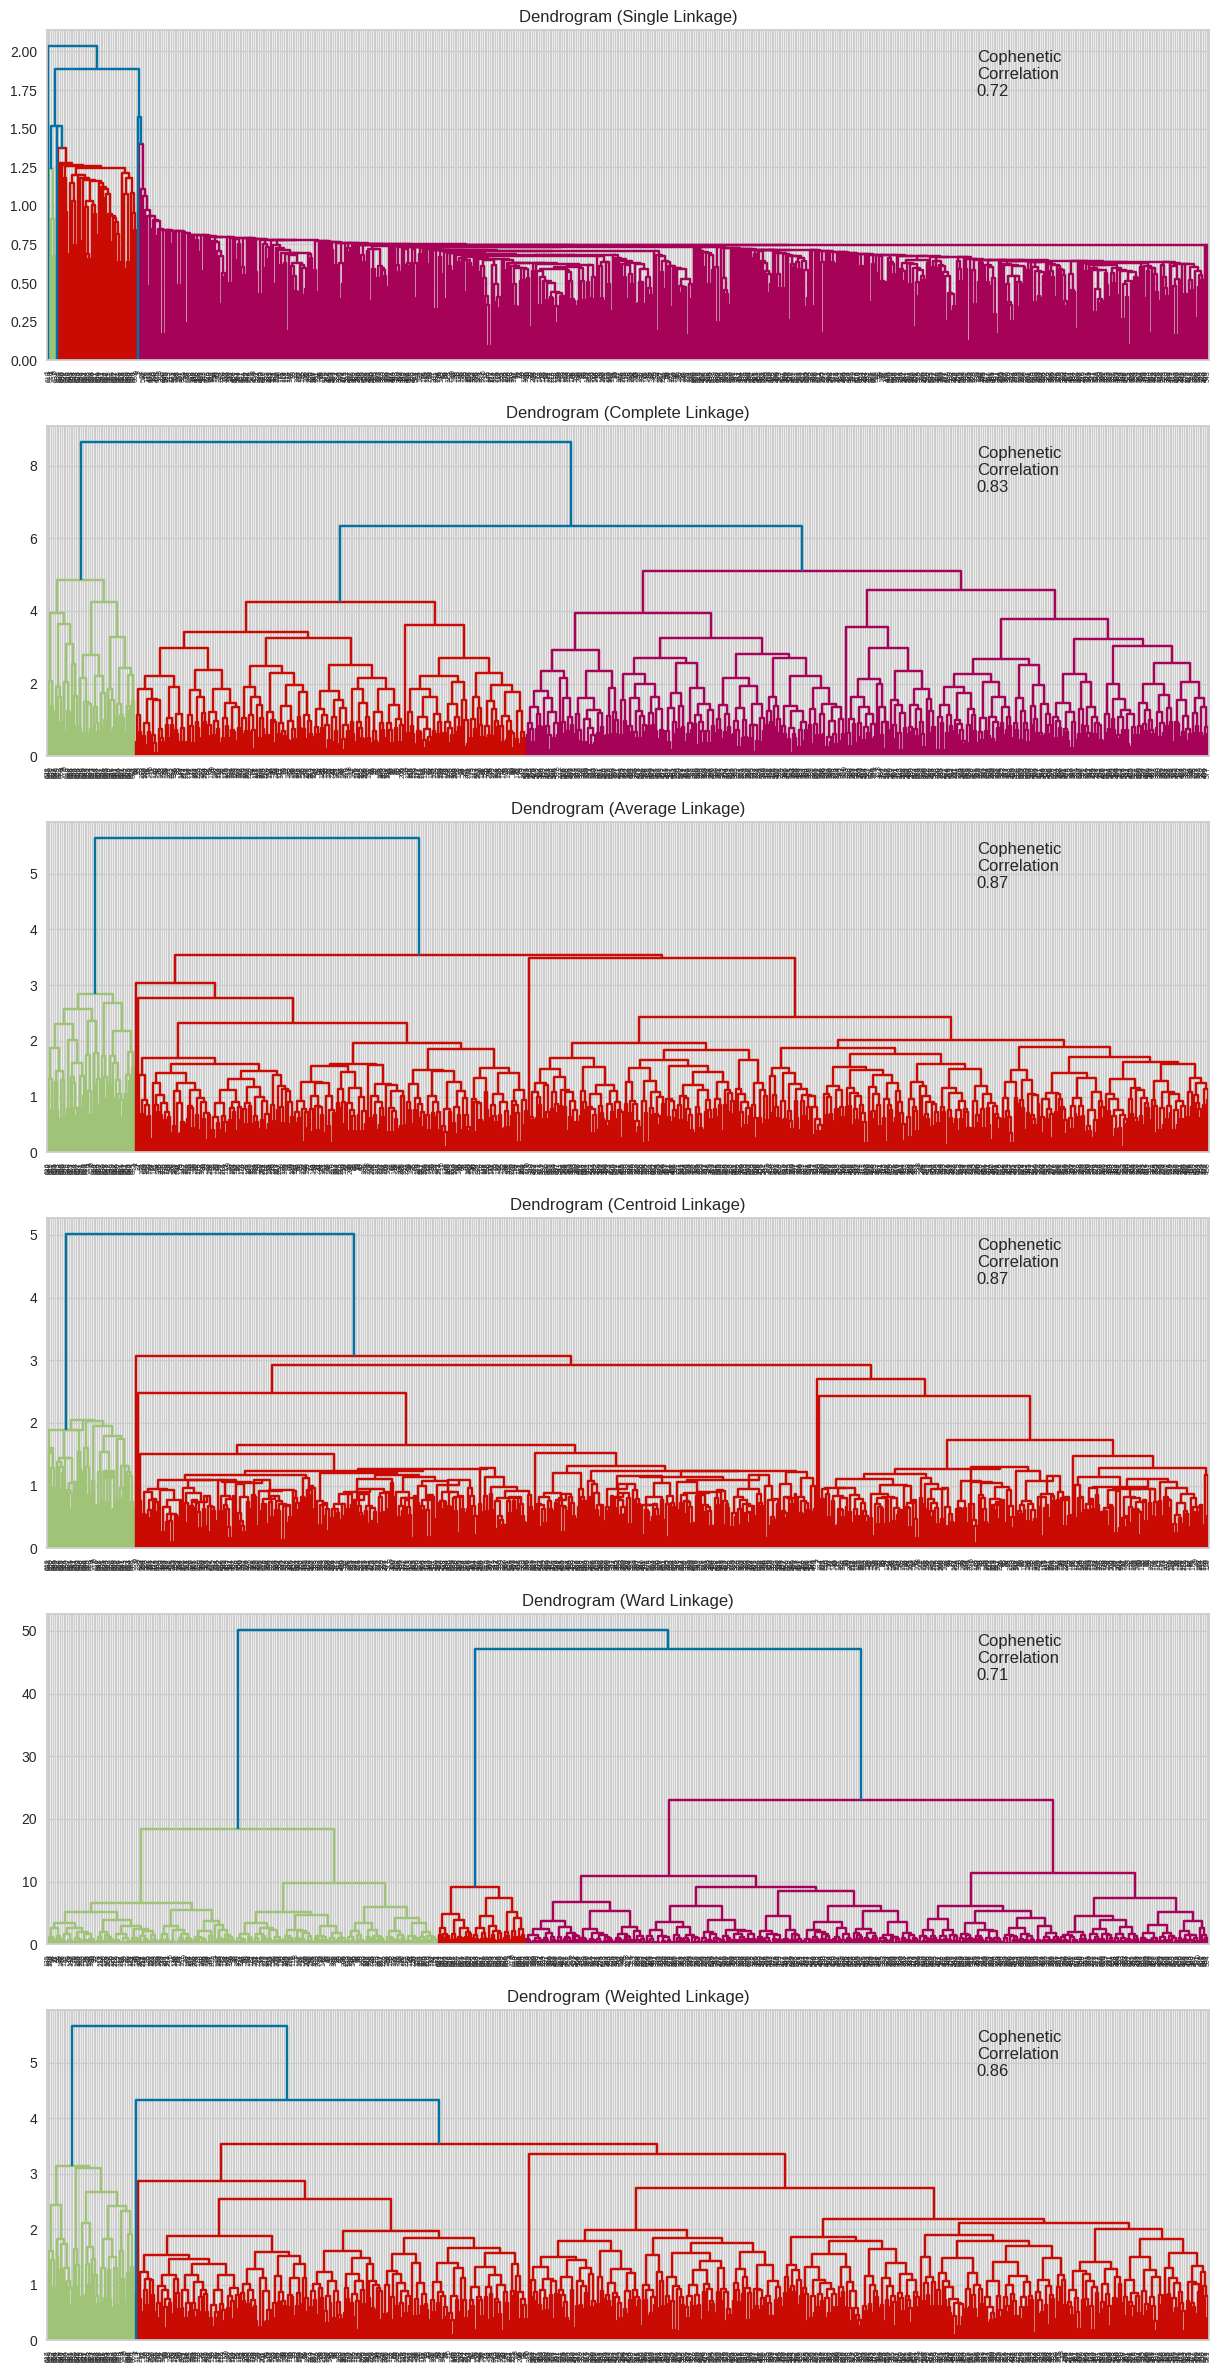

In [275]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Observations**

- The cophenetic correlation is highest for average and centroid linkage methods.
- From above dendrograms, the Ward linkage seems to result in the best separation between clusters, even though its cophenetic correlation is lower than the other linkages.
- We will move ahead with Ward linkage.
- 3 appears to be the appropriate number of clusters from the dendrogram for Ward linkage.

### Creating Final Model

**Let us try using Ward linkage as it has more distinct and separated clusters (as seen from it's dendrogram before). 3 appears to be the appropriate number of clusters from the dendrogram for Ward linkage.**

In [276]:
HCmodel = AgglomerativeClustering(n_clusters=3, metric="euclidean", linkage="ward")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(n_clusters=3)

In [277]:
subset_scaled_df["HC_segments"] = HCmodel.labels_
hc_df["HC_segments"] = HCmodel.labels_

### Cluster Profiling

In [278]:
pd.crosstab(hc_df.HC_segments, hc_df.total_visits_bank)

total_visits_bank,0,1,2,3,4,5
HC_segments,,,,,,
0,1,3,94,100,92,98
1,79,79,64,0,0,0
2,20,30,0,0,0,0


In [279]:
pd.crosstab(hc_df.HC_segments, hc_df.total_visits_online)

total_visits_online,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
HC_segments,,,,,,,,,,,,,,,,
0,144,107,135,2,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,54,42,69,54,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,7,6,4,5,5,6,5,1,10


In [280]:
pd.crosstab(hc_df.HC_segments, hc_df.total_calls_made)

total_calls_made,0,1,2,3,4,5,6,7,8,9,10
HC_segments,,,,,,,,,,,
0,81,75,72,82,78,0,0,0,0,0,0
1,0,0,1,0,30,29,39,35,30,32,26
2,16,15,18,1,0,0,0,0,0,0,0


In [281]:
pd.crosstab(hc_df.HC_segments, hc_df.total_credit_cards)

total_credit_cards,1,2,3,4,5,6,7,8,9,10
HC_segments,,,,,,,,,,
0,0,1,1,103,73,116,94,0,0,0
1,59,63,52,48,0,0,0,0,0,0
2,0,0,0,0,1,1,7,11,11,19


In [282]:
hc_profiling = hc_df.groupby("HC_segments").mean(numeric_only = True)
hc_profiling["count_of_customers"] = (
    hc_df.groupby("HC_segments")["customer_key"].count().values
)

In [283]:
# let's display cluster profiles
hc_profiling.style.highlight_max(color="blue", axis=0).highlight_min(color='green')

,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,count_of_customers
HC_segments,,,,,,,
0,54829.721649,33688.144330,5.505155,3.476804,0.987113,2.002577,388
1,55333.256757,12144.144144,2.400901,0.932432,3.567568,6.909910,222
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50


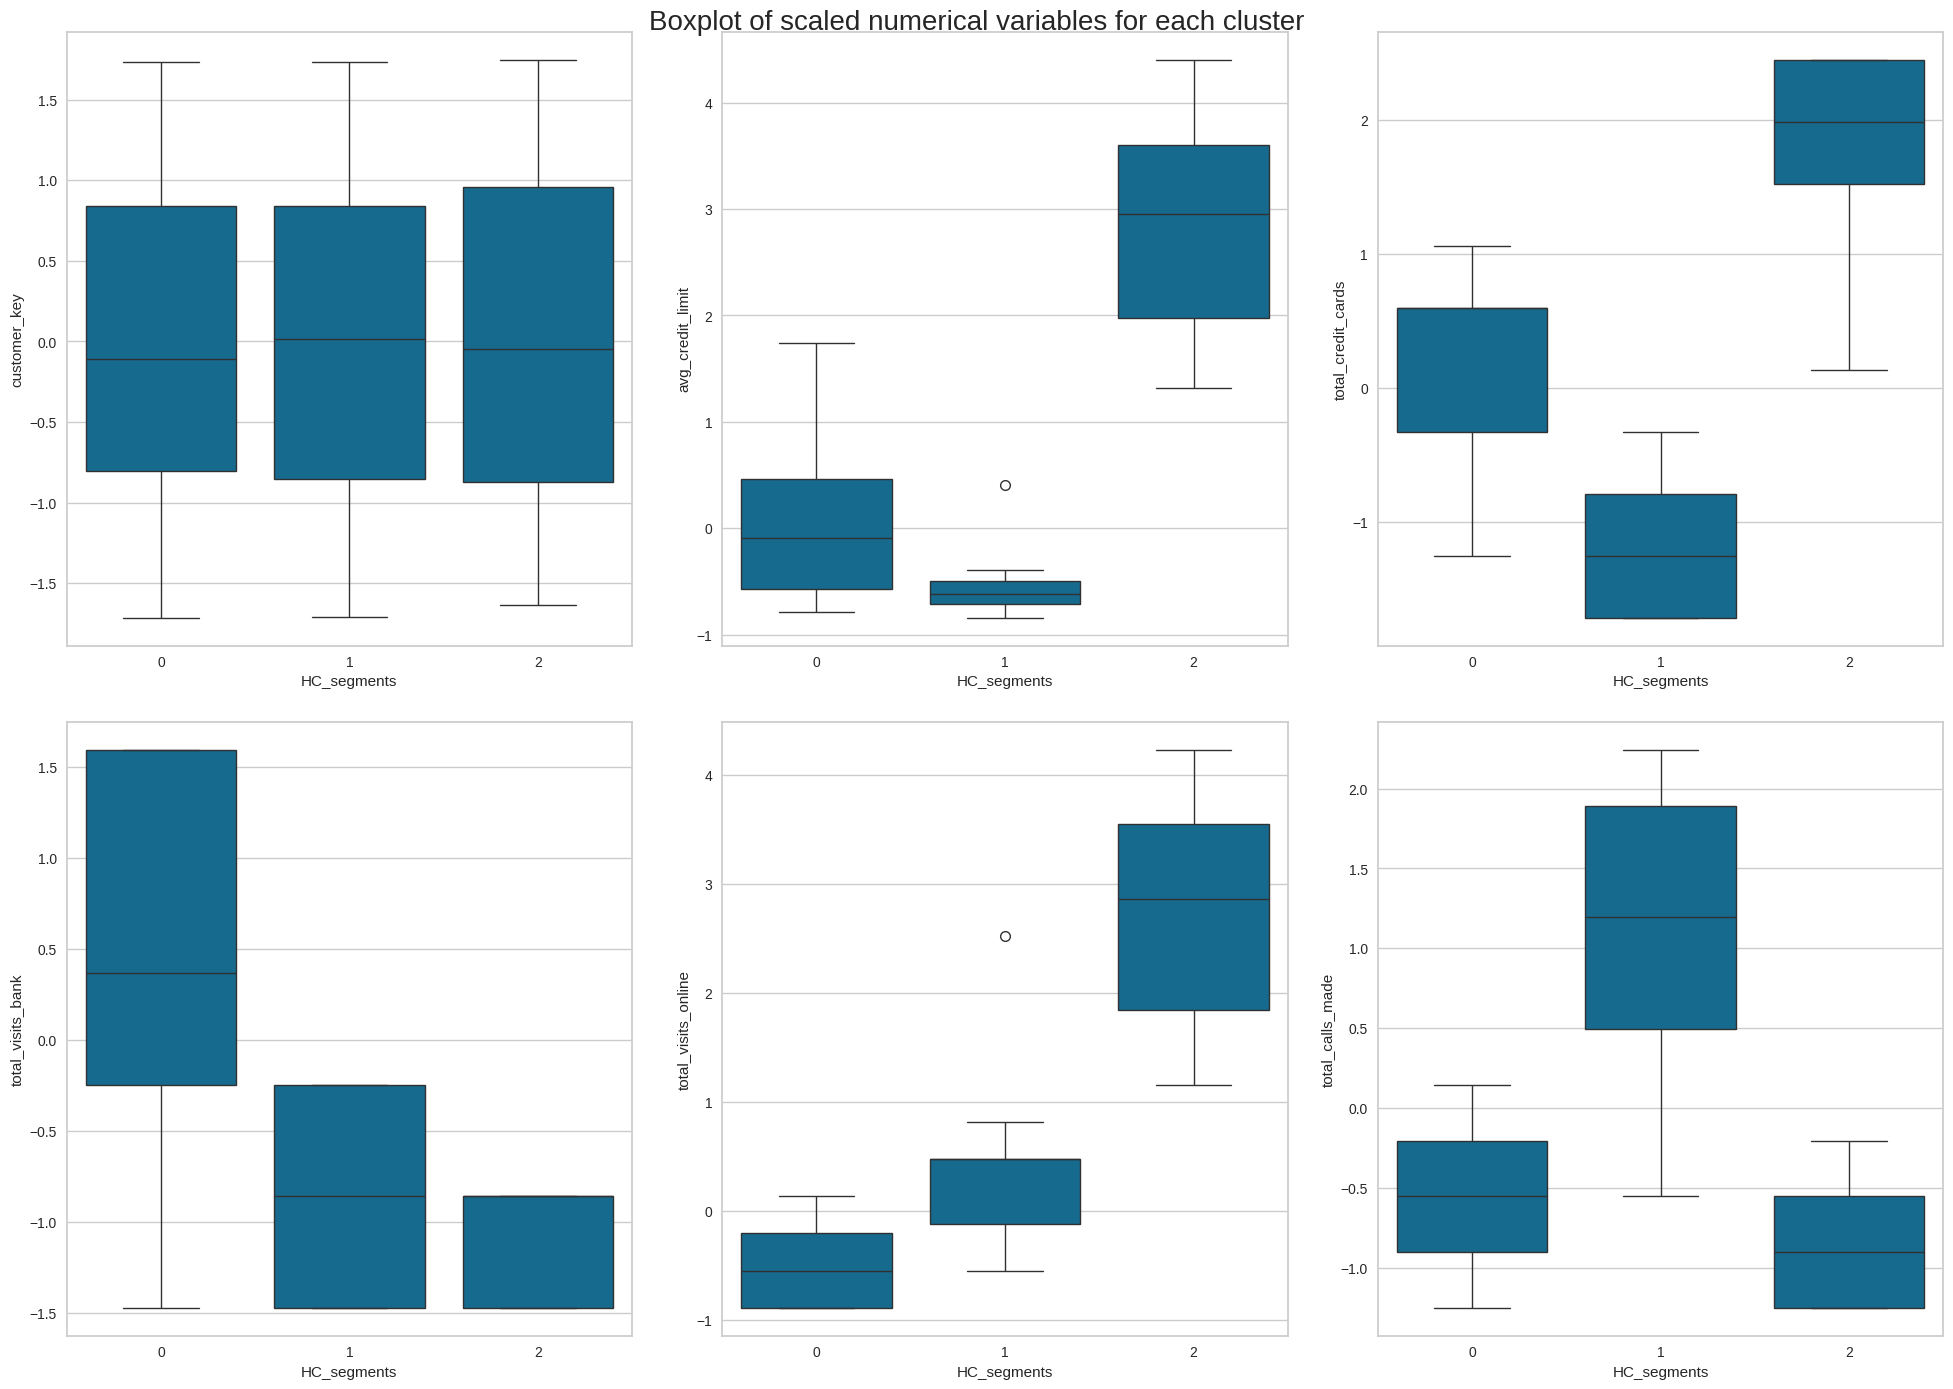

In [284]:
plt.figure(figsize=(20, 35))
plt.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)

for i, variable in enumerate(numeric_columns):
    plt.subplot(5, 3, i + 1)
    sns.boxplot(data=subset_scaled_df, x="HC_segments", y=variable)

plt.tight_layout(pad=2.0)

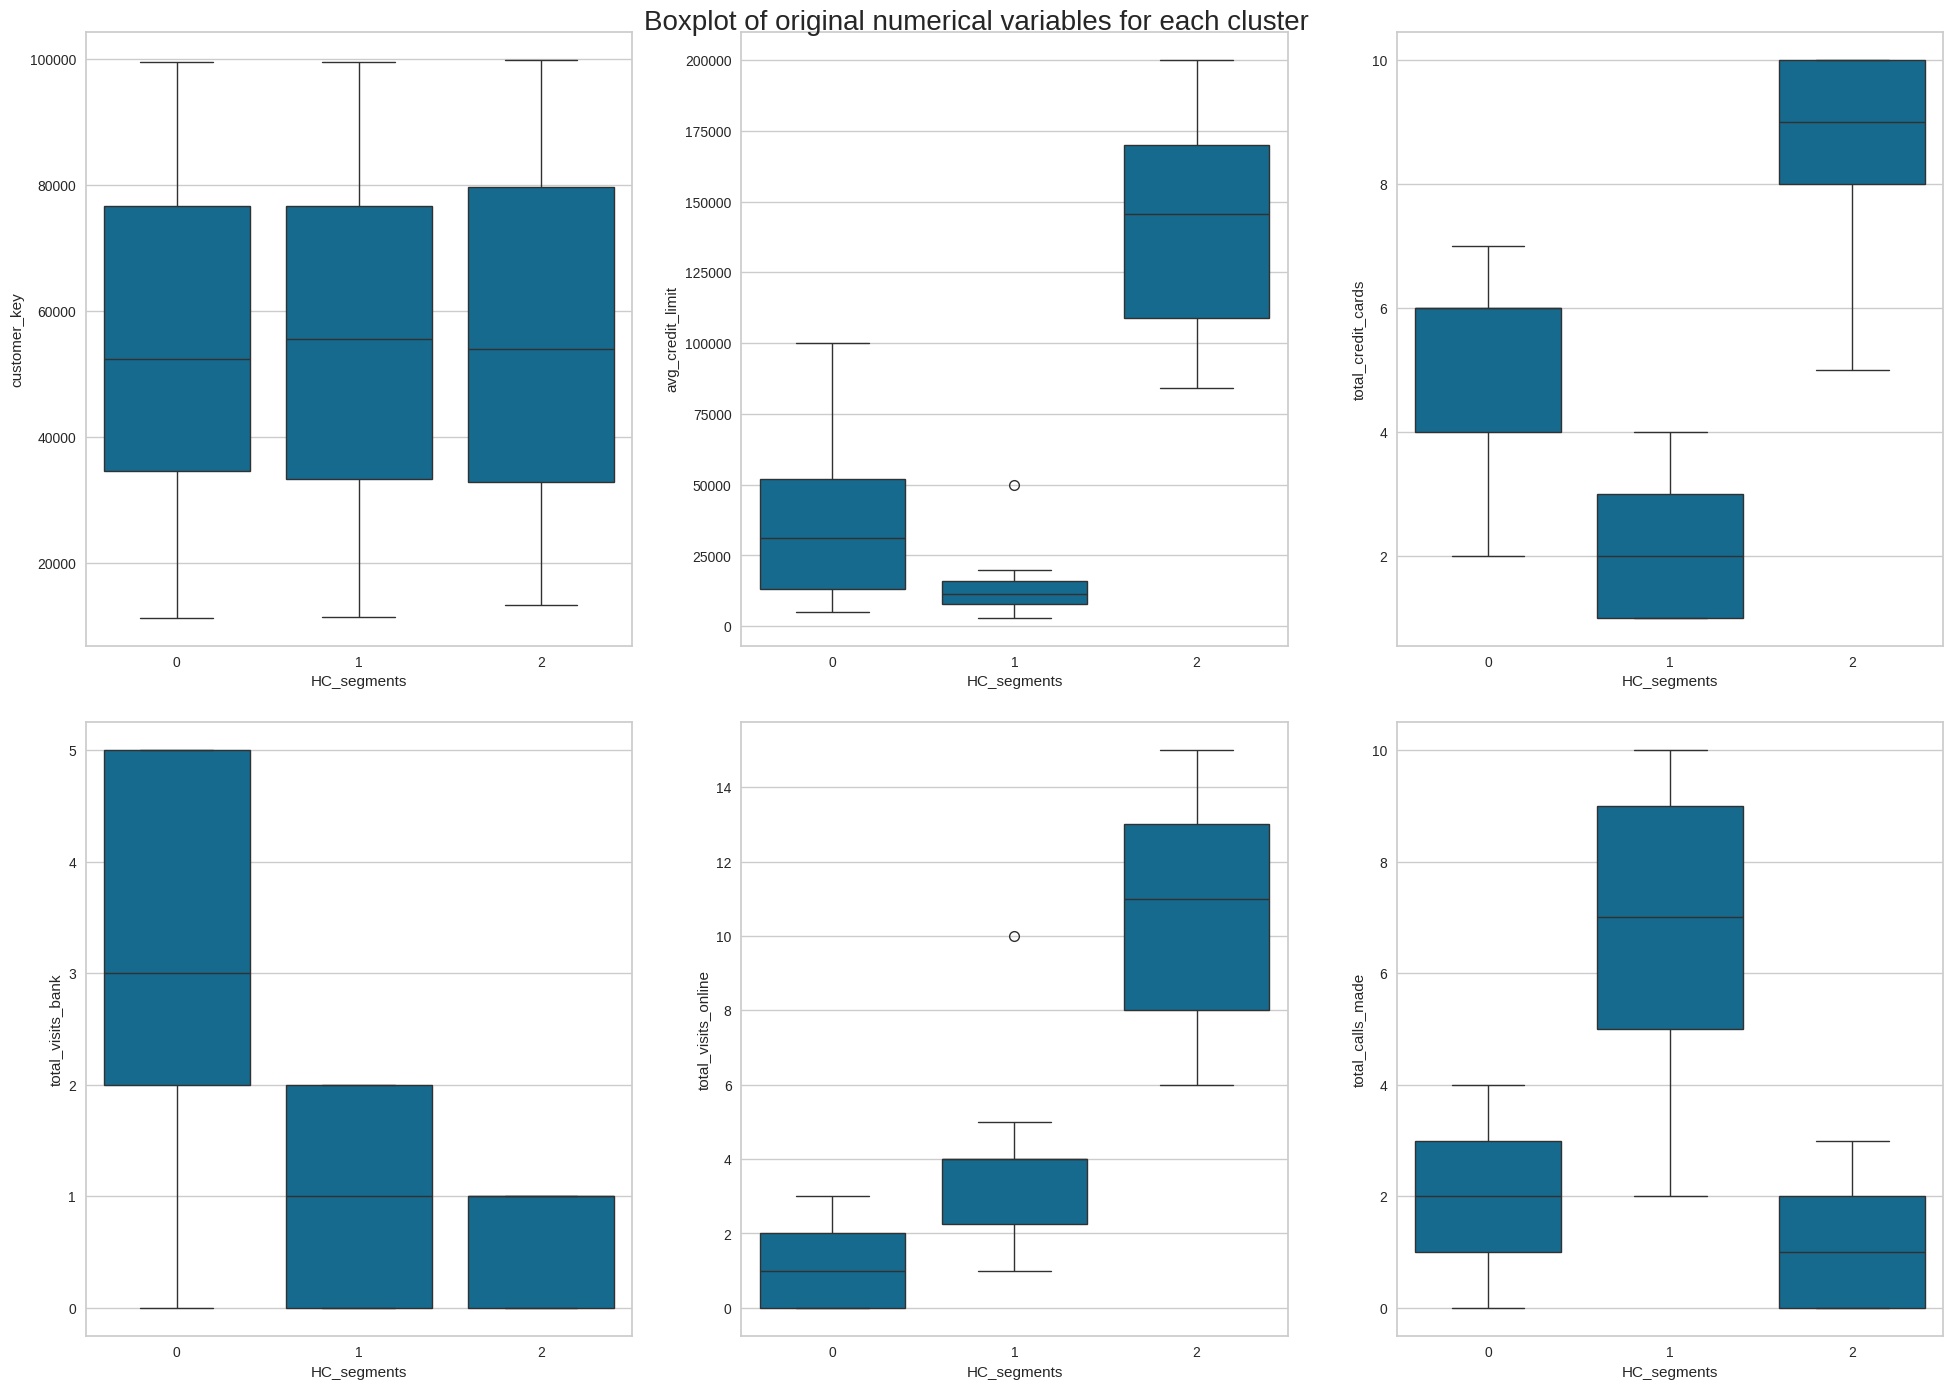

In [285]:
plt.figure(figsize=(20, 35))
plt.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)

for i, variable in enumerate(numeric_columns):
    plt.subplot(5, 3, i + 1)
    sns.boxplot(data=hc_df, x="HC_segments", y=variable)

plt.tight_layout(pad=2.0)

### Insights

**Cluster 0**:
  - The average credit limit for this cluster is under $33,782.
  - The maximum number of credit cards allowed in this cluster is 7 and minimum 2.
  - In this cluster, we can see a maximum of 5 (highest) visits overall to the bank.
  - In this cluster, we can only see a maximum of 3 visits on online.
  - In this cluster, there have been a maximum of 4 calls and no calls for some cases.
  - Customers in this cluster prefer to visit bank the most than online and they have credit cards and credit limits in the middle. Most number of customers are of this type.

**Cluster 1**:
  - The average credit limit limits in this cluster are greater than $12,174.
  - The maximum number of credit cards allowed in this cluster is 4 and minimum 1 (least usage).
  - In this cluster, customers visit the bank once or twice or never.
  - In this cluster, we can see a maximum of 5 visits on online.
  - In this cluster, total number of calls made ranges from 1 to 10 (highest).
  - Customers in this cluster prefer contacting the bank via phonecall the most and they have less credit cards and credit limit.

**Cluster 2**:
  - The average credit limit for this cluster is $141,040.
  - The maximum number of credit cards allowed in this cluster is 10 (highest) and minimum 5.
  - In this cluster, customers visit the bank once or never.
  - In this cluster, we can see a maximum of 15 and minimum of 6 visits on online.
  - In this cluster, there have been a maximum of 3 calls and no calls for some cases.
  - Customers in this cluster prefer using their bank's website for transactions the most than visiting the bank in-person and they have more credit cards and larger credit limit. Least number of customers are of this type.


## K-means vs Hierarchical Clustering

In [286]:
km_profiling.style.highlight_max(color="blue", axis=0)

,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,count_of_customers
KM_segments,,,,,,,
0,54881.329016,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,55239.830357,12174.107143,2.410714,0.933036,3.553571,6.870536,224


In [287]:
hc_profiling.style.highlight_max(color="blue", axis=0)

,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,count_of_customers
HC_segments,,,,,,,
0,54829.721649,33688.144330,5.505155,3.476804,0.987113,2.002577,388
1,55333.256757,12144.144144,2.400901,0.932432,3.567568,6.909910,222
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50


**Observations**

- Looks like the K-Means and Hierarchical clusters are similar, except that the labels are swapped between clusters 1 and 2.
- Let's swap the labels for K-Means for better analysis and comparison.

In [288]:
km_df["KM_segments"] = km_df["KM_segments"].replace({1: 2, 2: 1})

km_profiling = km_df.groupby("KM_segments").mean(numeric_only = True)
km_profiling["count_of_customers"] = (
    km_df.groupby("KM_segments")["customer_key"].count().values
)

In [289]:
km_profiling.style.highlight_max(color="green", axis=0)

,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,count_of_customers
KM_segments,,,,,,,
0,54881.329016,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,55239.830357,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000,50


In [290]:
pd.crosstab(km_df.KM_segments, km_df.total_visits_bank)

total_visits_bank,0,1,2,3,4,5
KM_segments,,,,,,
0,0,3,93,100,92,98
1,80,79,65,0,0,0
2,20,30,0,0,0,0


In [291]:
pd.crosstab(hc_df.HC_segments, hc_df.total_visits_bank)

total_visits_bank,0,1,2,3,4,5
HC_segments,,,,,,
0,1,3,94,100,92,98
1,79,79,64,0,0,0
2,20,30,0,0,0,0


In [292]:
pd.crosstab(km_df.KM_segments, km_df.total_visits_online)

total_visits_online,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
KM_segments,,,,,,,,,,,,,,,,
0,144,106,135,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,3,54,43,69,54,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,7,6,4,5,5,6,5,1,10


In [293]:
pd.crosstab(hc_df.HC_segments, hc_df.total_visits_online)

total_visits_online,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
HC_segments,,,,,,,,,,,,,,,,
0,144,107,135,2,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,54,42,69,54,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,7,6,4,5,5,6,5,1,10


In [294]:
pd.crosstab(km_df.KM_segments, km_df.total_calls_made)

total_calls_made,0,1,2,3,4,5,6,7,8,9,10
KM_segments,,,,,,,,,,,
0,81,74,72,82,77,0,0,0,0,0,0
1,0,1,1,0,31,29,39,35,30,32,26
2,16,15,18,1,0,0,0,0,0,0,0


In [295]:
pd.crosstab(hc_df.HC_segments, hc_df.total_calls_made)

total_calls_made,0,1,2,3,4,5,6,7,8,9,10
HC_segments,,,,,,,,,,,
0,81,75,72,82,78,0,0,0,0,0,0
1,0,0,1,0,30,29,39,35,30,32,26
2,16,15,18,1,0,0,0,0,0,0,0


-	K-Means was faster than Hierarchical Clustering.
-	In both the methods we obtain 3 clusters.
-	The count of data in each cluster in K-means clustering is [0: 386, 1: 224, 2: 50] and in Hierarchical clustering is [0: 388, 1: 222, 2: 50].
-	Both the models are giving similar. A few points have swapped the clusters between 0 and 1 in K-means and Hierarchical clustering.


## Dimensionality Reduction using PCA for visualization

Let's use PCA to reduce the data to two dimensions and visualize it to see how well-separated the clusters are.

In [296]:
# importing library
from sklearn.decomposition import PCA

# setting the number of components to 2
pca = PCA(n_components=2)

# transforming data and storing results in a dataframe
X_reduced_pca = pca.fit_transform(subset_scaled_df)
reduced_df_pca = pd.DataFrame(
    data=X_reduced_pca, columns=["Component 1", "Component 2"]
)

In [297]:
print(
    "Explained variance per principal component: {}".format(
        pca.explained_variance_ratio_
    )
)

Explained variance per principal component: [0.36332631 0.3408062 ]


In [298]:
# checking the amount of variance explained
pca.explained_variance_ratio_.sum()

0.7041325149776483

**Observations**

- In the above result, the explained variance is shown.

    - The first principal component explains 36.33% of total variance in the data.
    - The second principal component explains 34.08% of total variance in the data.
    - Both the can components explain 70.42% of the variance in the data.

- We can see reduction in dimensions, from 7 to 2, and the 2 dimensions explain nearly 70% of total variance in the data.

### Visualizing the data in the lower dimension

<Axes: xlabel='Component 1', ylabel='Component 2'>

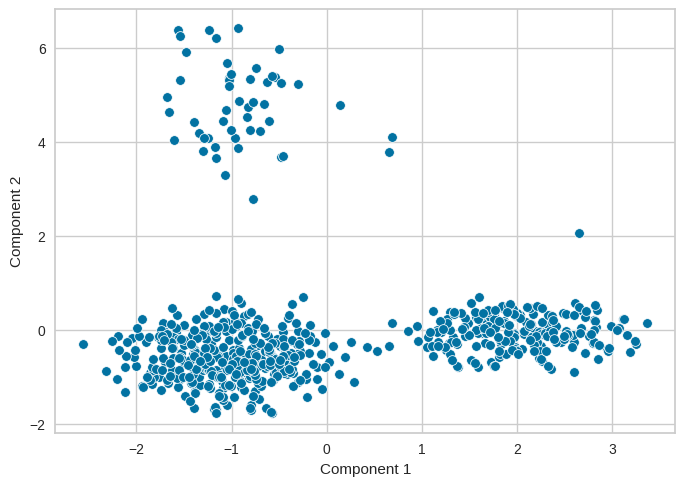

In [299]:
sns.scatterplot(data=reduced_df_pca, x="Component 1", y="Component 2")

Let's colour the scatterplot by cluster labels.

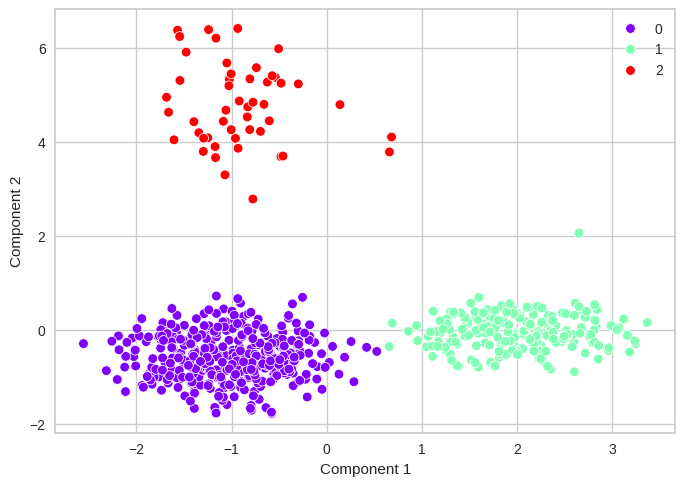

In [300]:
sns.scatterplot(
    data=reduced_df_pca,
    x="Component 1",
    y="Component 2",
    hue=hc_df["HC_segments"],
    palette="rainbow",
)
plt.legend(bbox_to_anchor=(1, 1))

- Cluster 0 and 1 are the major clusters. Few points are there in the cluster 2.
- All the clusters are very well separated.

## Actionable Insights & Recommendations

### Actionable Insights

Both the algorithms gave very similar results and there are 3 different categories of customers in the AllLife bank.

- In-person customers: This type of users prefer visiting the bank in-person for their transactions the most. They have medium number of credit cards and medium credit limits. Most number of customers have this type of preference.
- Online customers: This type of users prefer using their bank's website for transactions the most. They have large number of credit cards and highest credit limit. Least number of customers have this type of preference.
- Phone call customers: This type of users prefer contacting the bank via phone call the most for their transactions. They have least number of credit cards and lowest credit limit.


### Recommendations


- Customers should be contacted according to their preference.
  - Online users have highest credit limit, so we promote them using email and Ads in banking website. We can provide mobile apps for banking to the online users which make the service easier for the users.
  - Phone users will prefer text messages or call notifications, So can make monthly phone call to these customers to promote new services or schemes provided by the bank.
  - For in-person customers we need to explain or promote online/phone-call service provided by the bank, so that they can access the banking service remotely instead of visiting bank for each and every transaction or doubt.
- Target customers with a lower credit limit and the least number of credit cards by educating them with banking resources. Free campaign can be made to promote customer's financial knowledge.
- Customers purchase more credit card if they can earn something in return like cashback, reward points or discounts. So provide rewards to the customers.
- Ask feedback or take survey from the customers of all mode, so that we can enhance our facilities in banking.
